In [1]:
import sys
sys.path.insert(0, "../src")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year
import pickle
import xarray as xr
import math
from tabulate import tabulate
ssps = ['ssp126','ssp245','ssp370','ssp585']
geos = ['ASIA','REF', 'LAM', 'MAF', 'OECD']
species = ['CO2', 'CH4', 'SULFUR', 'BC', 'NH3', 'NOx', 'VOC', 'CO']#'OC']
no_change = ['normal_fair', 'ch4_no_aircraft_ref1850', 'ch4_no_solvents_production_and_application_ref1850', 
             'sulfur_no_agriculture_ref1850', 'sulfur_no_solvents_production_and_application_ref1850', 'bc_no_agriculture_ref1850', 
             'bc_no_solvents_production_and_application_ref1850', 'oc_no_agriculture_ref1850', 'oc_no_solvents_production_and_application_ref1850', 
             'nh3_no_solvents_production_and_application_ref1850', 'nox_no_solvents_production_and_application_ref1850', 'voc_no_agriculture_ref1850', 
             'co_no_agriculture_ref1850', 'co_no_solvents_production_and_application_ref1850', 'co2_no_solvents_production_and_application_ref1850', 
             'ch3ccl3_no_ch3ccl3_ref1850', 'halon1202_no_halon1202_ref1850', 'magicc_afolu_no_magicc_afolu_ref1850']

In [2]:
fair_og = pd.read_csv("no_specie_differences_ref1850.csv")
fair_og['prefix'] = fair_og['pickle_filename'].str.split('_').str[0]
fair = (fair_og.sort_values(by='prefix')).copy()
fair = fair.drop('prefix', axis=1)
fair.to_csv('no_specie_differences_ref1850.csv', index=False)
fair = pd.read_csv("no_specie_differences_ref1850.csv")
columns_to_multiply = ['ssp126_gmst', 'ssp245_gmst', 'ssp370_gmst', 'ssp585_gmst']

In [7]:
for specie in species:
    locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != specie]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][~locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos))]
    exclude_keywords = ['magicc_afolu', 'magicc_fossil_and_industrial']
    locals()[f'fair_{specie}_mod'] = locals()[f'fair_{specie}']#[~locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(exclude_keywords), case=False, na=False)].copy()
    # total_values = locals()[f'fair_{specie}_mod'].sum(numeric_only=True)
    # locals()[f'fair_{specie}'].loc['total'] = total_values
    # locals()[f'fair_{specie}'].loc['total', 'pickle_filename'] = 'total'
    if specie == 'voc':
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp585_gmst', ascending=False)
    else:
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp370_gmst', ascending=False)

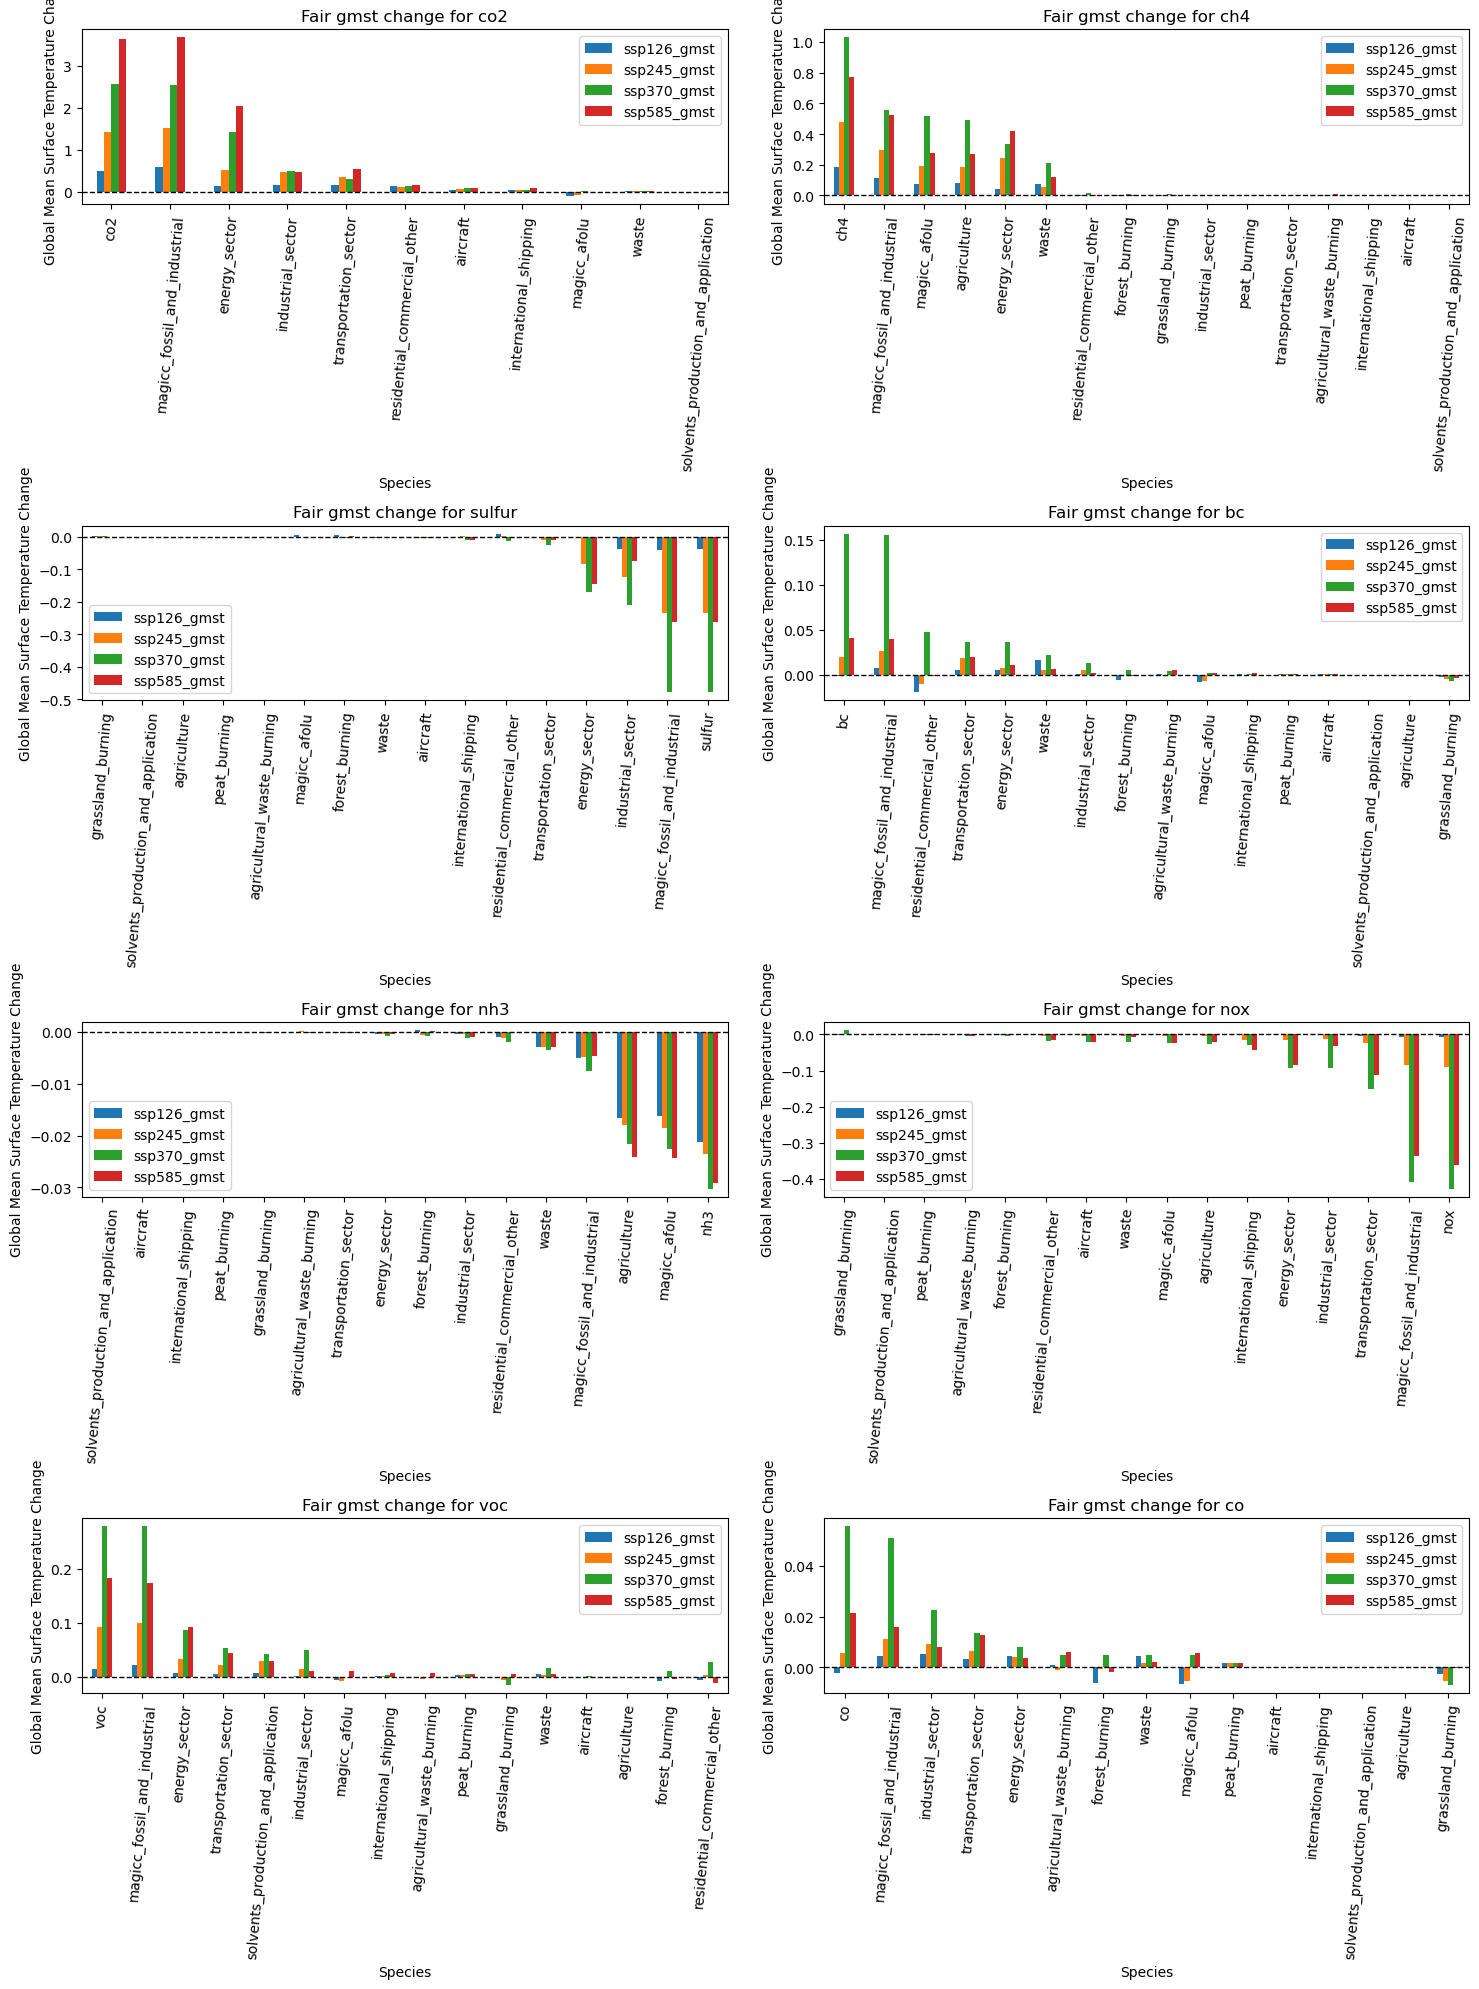

In [13]:
species = [specie.lower() for specie in species]
per_row = 2
num_rows = int(np.ceil(len(species) / per_row))
fig, axs = plt.subplots(num_rows, per_row, figsize=(15, num_rows * 5))
for specie in species:
    #locals()[f'fair_{specie}'][columns_to_multiply] *= -1
    if specie == 'co':
        locals()[f'fair_{specie}'] = fair[fair['pickle_filename'].str.contains('co', case=False, na=False)].copy()
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('commercial', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('co2', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != 'co']
    elif specie == 'oc':
        locals()[f'fair_{specie}'] = fair[fair['pickle_filename'].str.contains('oc', case=False, na=False)].copy()
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('voc', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != 'oc']
    else:
        locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    #total_values = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] == specie]
    #locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != specie]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != 'total']
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][~locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos))]
    # exclude_keywords = ['magicc_afolu', 'magicc_fossil_and_industrial']
    # for exclude_keyword in exclude_keywords:
    #     locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains(exclude_keyword, case=False, na=False)].index)
    for name in no_change:
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains(name, case=False, na=False)].index)
    locals()[f'fair_{specie}_mod'] = locals()[f'fair_{specie}'].copy()
    #total_values = locals()[f'fair_{specie}_mod'].sum(numeric_only=True)
    #total_values = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] == specie
    # locals()[f'fair_{specie}'].loc['total'] = total_values
    # locals()[f'fair_{specie}'].loc['total', 'pickle_filename'] = 'total'
    if specie == 'voc':
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp585_gmst', ascending=False)
    else:
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp370_gmst', ascending=False)
    #locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp370_gmst', ascending=False)
    #ax.legend([])
for i, specie in enumerate(species):
    handles, labels = [], []
    for ssp_color, ssp in zip(['blue', 'orange', 'green', 'red'], ssps):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ssp_color, markersize=10))
        labels.append(ssp)
    ax = axs[i // per_row][i % per_row]
    #ax.legend(handles, labels)
    locals()[f'fair_{specie}'].plot.bar(x='pickle_filename',ax=ax)
    ax.set_title(f'Fair gmst change for {specie}')
    ax.set_xlabel('Species')
    ax.set_ylabel('Global Mean Surface Temperature Change')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # if specie != 'CO2':
    #     ax.legend().set_visible(False)
    ax.tick_params(axis='x', rotation=85)
    #ax.invert_yaxis()
plt.tight_layout()
plt.show()
#fig.savefig(f'gmst_change_per_sector_per_ssp.pdf', format='pdf')

In [14]:
for specie in species:
    locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    #locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != specie]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos))]
    # total_values = locals()[f'fair_{specie}'].sum(numeric_only=True)
    # locals()[f'fair_{specie}'].loc['total'] = total_values
    # locals()[f'fair_{specie}'].loc['total', 'pickle_filename'] = 'total'
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp585_gmst', ascending=False)

In [15]:
for specie in species:
    locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    #locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos)) | locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] == specie]]
    condition1 = locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos))
    condition2 = locals()[f'fair_{specie}']['pickle_filename'] == specie
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][condition1 | condition2]
fair_ch4

,pickle_filename,ssp126%,ssp126_gmst,ssp245%,ssp245_gmst,ssp370%,ssp370_gmst,ssp585%,ssp585_gmst
60,ASIA,-5.670873%,0.062603,-7.879671%,0.177286,-9.688893%,0.398562,-4.352909%,0.129022
61,MAF,-3.550686%,0.059150,-4.464928%,0.121615,-6.504560%,0.347983,-7.142608%,0.354319
62,ch4,-15.123676%,0.187180,-19.607970%,0.476084,-24.376931%,1.030172,-18.501846%,0.770637
63,LAM,-3.600992%,0.053771,-3.807629%,0.094898,-4.362168%,0.188861,-2.655667%,0.092967
64,OECD,-1.291693%,0.009018,-1.703902%,0.046959,-2.446821%,0.088985,-2.627375%,0.137374
65,REF,-1.143080%,0.006813,-2.034858%,0.052653,-1.919573%,0.073313,-2.240730%,0.113803


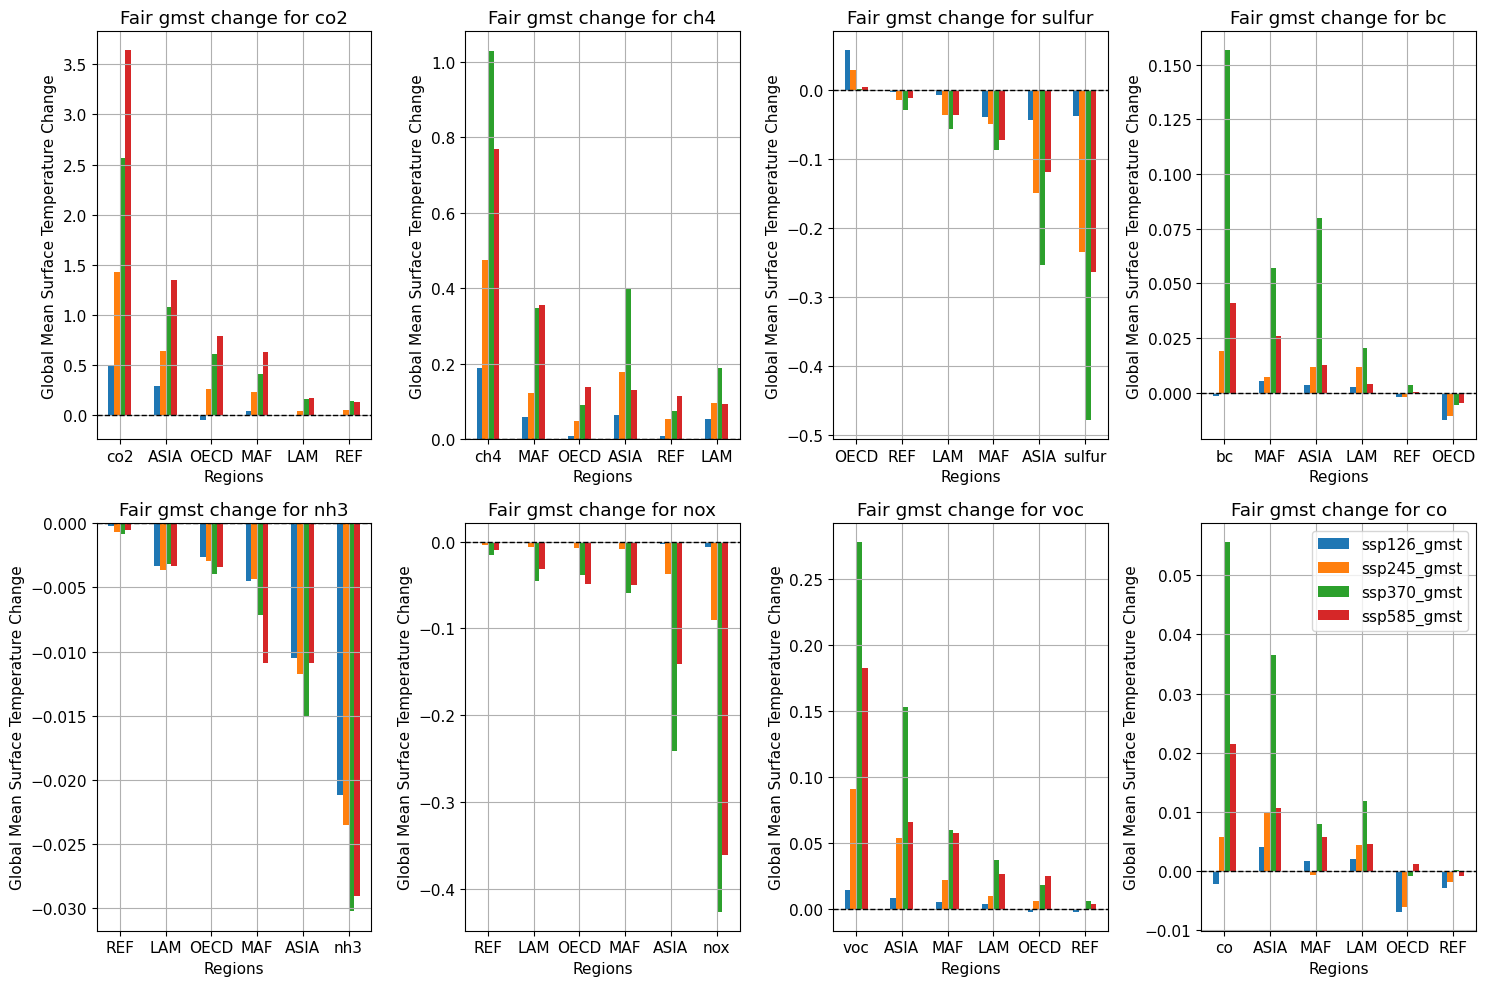

In [66]:
plt.rcParams.update({'font.size': 11})
species = ['CO2','CH4', 'SULFUR', 'BC', 'NH3', 'NOx', 'VOC', 'CO']
species = [specie.lower() for specie in species]
per_row = 4
num_rows = int(np.ceil(len(species) / per_row))
fig, axs = plt.subplots(num_rows, per_row, figsize=(15, num_rows * 5))
for specie in species:
    ax.legend([])
    locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    if specie == 'co':
        locals()[f'fair_{specie}'] = fair[fair['pickle_filename'].str.contains('co', case=False, na=False)].copy()
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('commercial', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('co2', case=False, na=False)].index)
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    condition1 = locals()[f'fair_{specie}']['pickle_filename'].str.contains('|'.join(geos))
    condition2 = locals()[f'fair_{specie}']['pickle_filename'] == specie
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][condition1 | condition2]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp585_gmst', ascending=False)
for i, specie in enumerate(species):
    ax.grid(True)
    handles, labels = [], []
    for ssp_color, ssp in zip(['blue', 'orange', 'green', 'red'], ssps):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=ssp_color, markersize=10))
        labels.append(ssp)
    ax = axs[i // per_row][i % per_row]
    locals()[f'fair_{specie}'].plot.bar(x='pickle_filename', ax=ax)
    ax.set_title(f'Fair gmst change for {specie}')
    ax.set_xlabel('Regions')
    ax.set_ylabel('Global Mean Surface Temperature Change')
    handles, labels = ax.get_legend_handles_labels()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    if specie != 'co':
        ax.legend().set_visible(False)
    ax.tick_params(axis='x', rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(f'gmst_change_per_region_per_ssp.png', format='png')

In [5]:
specie = 'ch4'
locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()

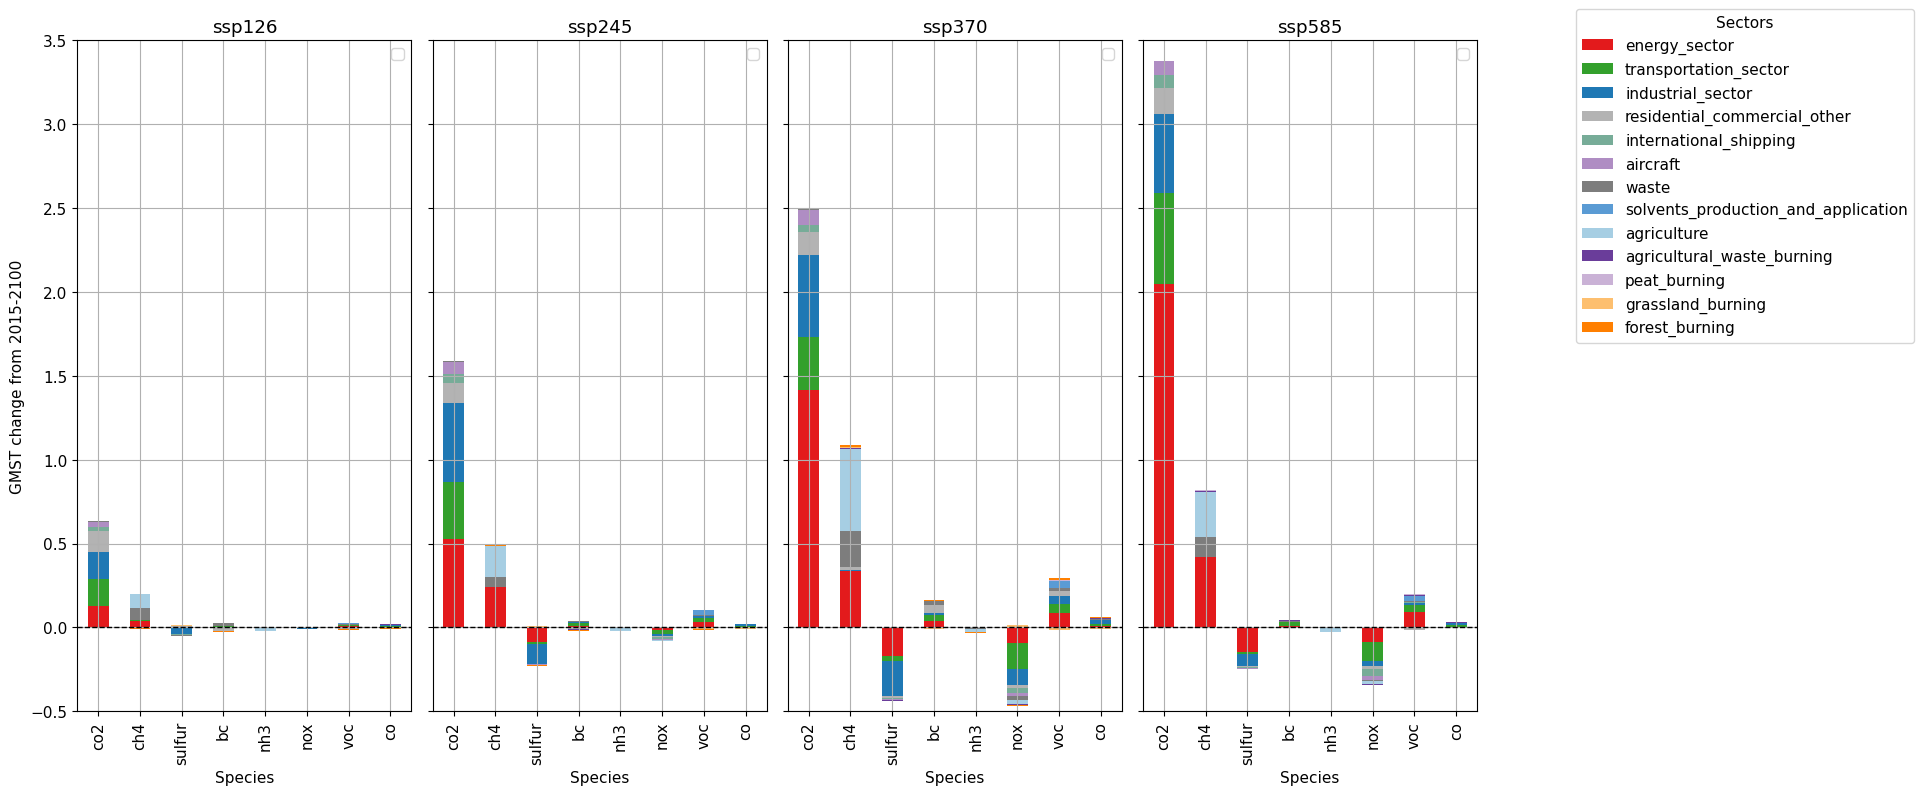

In [65]:
plt.rcParams.update({'font.size': 11})
species = ['CO2','CH4', 'SULFUR', 'BC', 'NH3', 'NOx', 'VOC', 'CO']
species = [specie.lower() for specie in species]
for ssp in ssps:
    locals()[f'fair_{ssp}'] = pd.DataFrame()
sector_colors = {
    'solvents_production_and_application': '#5a9bd4',  # Light Blue
    'waste': '#7d7d7d',  # Gray
    'aircraft': '#af8dc3',  # Purple
    'international_shipping': '#77ac98',  # Green
    'residential_commercial_other': '#b3b3b3',  # Light Gray
    'industrial_sector': '#1f78b4',  # Dark Blue
    'transportation_sector': '#33a02c',  # Dark Green
    'energy_sector': '#e31a1c',  # Red
    'grassland_burning': '#fdbf6f',  # Orange
    'forest_burning': '#ff7f00',  # Dark Orange
    'peat_burning': '#cab2d6',  # Lavender
    'agricultural_waste_burning': '#6a3d9a',  # Dark Purple
    'agriculture': '#a6cee3',  # Light Blue
}
for specie in species:
    ax.legend([])
    if specie == 'co':
        locals()[f'fair_{specie}'] = fair[fair['pickle_filename'].str.contains('co', case=False, na=False)].copy()
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('commercial', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('co2', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != 'co']
    elif specie == 'oc':
        locals()[f'fair_{specie}'] = fair[fair['pickle_filename'].str.contains('oc', case=False, na=False)].copy()
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].drop(locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'].str.contains('voc', case=False, na=False)].index)
        locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != 'oc']
    else:
        locals()[f'fair_{specie}'] = (fair[fair['pickle_filename'].str.contains(specie, case=False, na=False)]).copy()
    locals()[f'fair_{specie}']['pickle_filename'] = locals()[f'fair_{specie}']['pickle_filename'].str.replace(f'{specie}_no_', '').str.replace('_ref1850', '')
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][locals()[f'fair_{specie}']['pickle_filename'] != specie]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].set_index('pickle_filename')
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'].sort_values(by='ssp585_gmst', ascending=False)
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][~locals()[f'fair_{specie}'].index.str.contains('|'.join(geos))]
    # total_values = locals()[f'fair_{specie}'].sum(numeric_only=True)
    # locals()[f'fair_{specie}'].loc['total'] = total_values
    # locals()[f'fair_{specie}'].loc['total', 'pickle_filename'] = 'total'
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][~locals()[f'fair_{specie}'].index.str.contains('magicc_afolu')]
    locals()[f'fair_{specie}'] = locals()[f'fair_{specie}'][~locals()[f'fair_{specie}'].index.str.contains('magicc_fossil_and_industrial')]
    for ssp in ssps:
        column_name = f'{ssp}_gmst'
        locals()[f'fair_{specie}_{ssp}'] = locals()[f'fair_{specie}'][[column_name]].copy()
        locals()[f'fair_{specie}_{ssp}'].columns = [specie]
        locals()[f'fair_{ssp}'] = pd.concat([locals()[f'fair_{ssp}'], locals()[f'fair_{specie}_{ssp}']], axis=1)
# Create subplots
num_rows = 1#len(ssps) // 2 + (len(ssps) % 2 > 0)  # Calculate the number of rows needed
fig, axs = plt.subplots(1, 4, figsize=(15, 8 * num_rows),sharey='row')

# Flatten the axs array to handle cases where there is only one row
axs = axs.flatten()

# Iterate over ssps and create subplots
for i, ssp in enumerate(ssps):
    ax.grid(True)
    ax.legend([])
    ax = axs[i]
    
    # Rest of your existing code for processing data...
    # ...
    
    # Rest of your existing code for each subplot...
    locals()[f'fair_{ssp}'] = locals()[f'fair_{ssp}'].transpose()
    ax = locals()[f'fair_{ssp}'].plot.bar(stacked=True, color=sector_colors, ax=ax)
    
    # Set labels and title
    ax.set_xlabel('Species')#, rotation=85)  # Rotate x-axis labels
    ax.set_ylabel('GMST change from 2015-2100')
    ax.set_title(f'{ssp}')
    ax.set_ylim([-.5, 3.5])
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.legend([])
ax.grid(True)
# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, title='Sectors', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.savefig(f'gmst_change_per_specie_per_sector_per_ssp.png', format='png', bbox_inches='tight')
# Show the plots
plt.show()

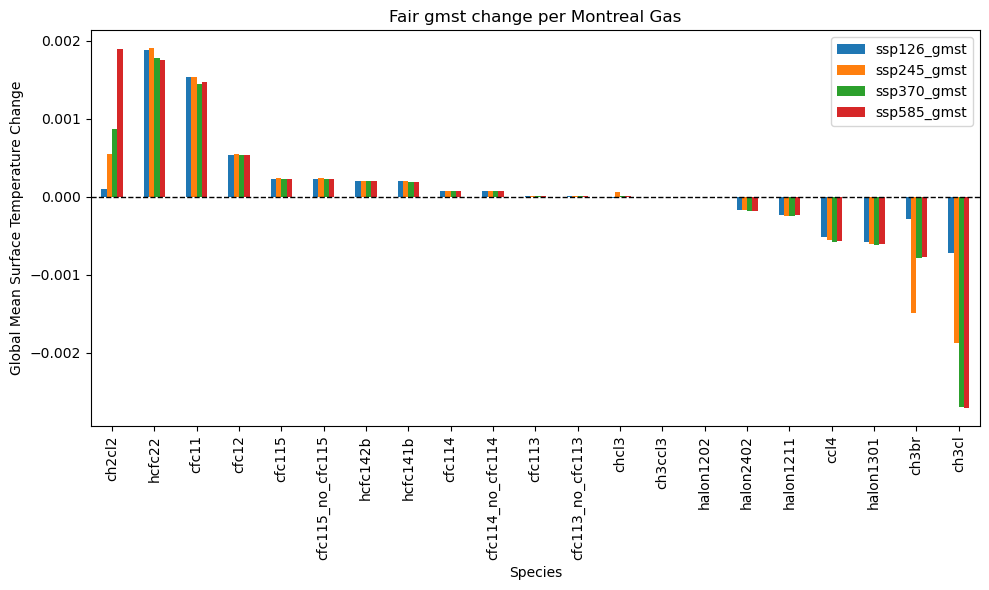

In [33]:
mon_gases = ['CFC11', 'CFC12', 'CFC113', 'CFC114', 'CFC115', 'HCFC22', 'HCFC141b', 'HCFC142b', 'CCl4', 'CHCl3', 'CH2Cl2', 
             'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon1202', 'Halon1211', 'Halon1301', 'Halon2402']
f_gases = ['CF4', 'C2F6', 'C3F8', 'cC4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC125', 'HFC134a', 
           'HFC143a', 'HFC152a', 'HFC227ea', 'HFC23', 'HFC236fa', 'HFC245fa', 'HFC32', 'HFC365mfc', 'HFC4310mee']
for no_gas in no_change:
    for mon_gas in mon_gases:
        if no_gas == mon_gas:
            mon_gases.remove(mon_gas)
mon_gases = [mon_gas.lower() for mon_gas in mon_gases]
moon_gas = pd.DataFrame()
for mon_gas in mon_gases:
    #ax.legend([])
    locals()[f'fair_{mon_gas}'] = (fair[fair['pickle_filename'].str.contains(mon_gas, case=False, na=False)]).copy()
    locals()[f'fair_{mon_gas}']['pickle_filename'] = locals()[f'fair_{mon_gas}']['pickle_filename'].str.replace(f'{mon_gas}_no_', '').str.replace('_ref1850', '')
    moon_gas = pd.concat([moon_gas,locals()[f'fair_{mon_gas}']], ignore_index=True)
    
moon_gas = moon_gas.sort_values(by='ssp585_gmst', ascending=False)

ax = moon_gas.plot.bar(x='pickle_filename', figsize=(10, 6))
ax.set_ylabel('Global Mean Surface Temperature Change')
ax.set_xlabel('Species')
ax.set_title(f'Fair gmst change per Montreal Gas')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
ax.get_figure().savefig('gmst_change_per_mon_gas_per_ssp.png', format='png')

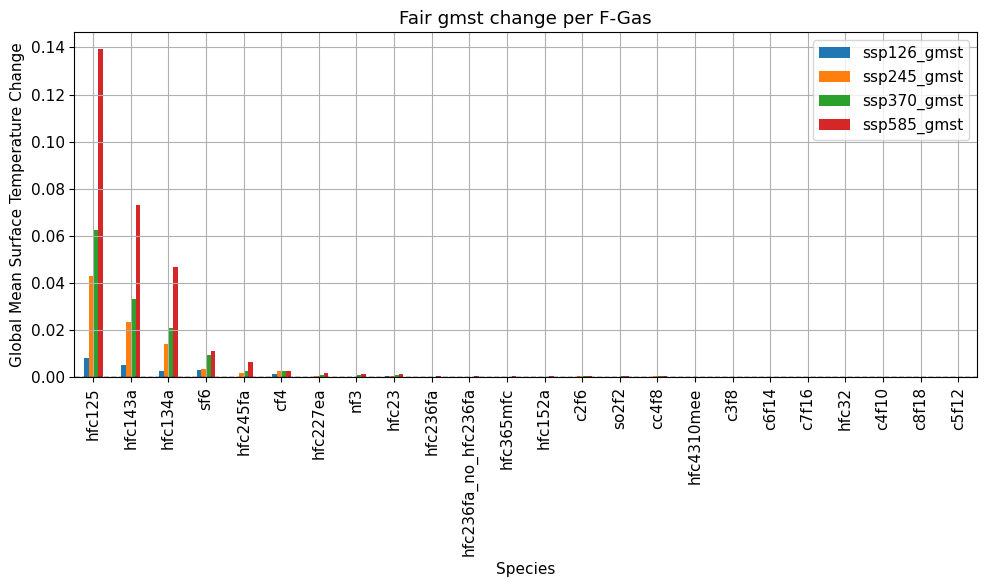

In [64]:
plt.rcParams.update({'font.size': 11})
mon_gases = ['CF4', 'C2F6', 'C3F8', 'cC4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC125', 'HFC134a', 
           'HFC143a', 'HFC152a', 'HFC227ea', 'HFC23', 'HFC236fa', 'HFC245fa', 'HFC32', 'HFC365mfc', 'HFC4310mee']
for no_gas in no_change:
    for mon_gas in mon_gases:
        if no_gas == mon_gas:
            mon_gases.remove(mon_gas)
mon_gases = [mon_gas.lower() for mon_gas in mon_gases]
moon_gas = pd.DataFrame()
for mon_gas in mon_gases:
    #ax.legend([])
    locals()[f'fair_{mon_gas}'] = (fair[fair['pickle_filename'].str.contains(mon_gas, case=False, na=False)]).copy()
    locals()[f'fair_{mon_gas}']['pickle_filename'] = locals()[f'fair_{mon_gas}']['pickle_filename'].str.replace(f'{mon_gas}_no_', '').str.replace('_ref1850', '')
    moon_gas = pd.concat([moon_gas,locals()[f'fair_{mon_gas}']], ignore_index=True)
    
moon_gas = moon_gas.sort_values(by='ssp585_gmst', ascending=False)

ax = moon_gas.plot.bar(x='pickle_filename', figsize=(10, 6))
ax.set_ylabel('Global Mean Surface Temperature Change')
ax.set_xlabel('Species')
ax.set_title(f'Fair gmst change per F-Gas')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.grid(True)
plt.tight_layout()
plt.show()
ax.get_figure().savefig('gmst_change_per_f_gas_per_ssp.png', format='png')